In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

## Load data & merge datasets

In [2]:
actors_df = pd.read_csv('data/preprocessed/lead_actors_data_on_subset_movie.csv')
movie_df = pd.read_csv('data/preprocessed/subset_movie_with_full_data_on_lead_actors.csv')

In [3]:
merged_actors_movies = actors_df.merge(movie_df, on='wikipedia_movie_id',how='inner')
merged_actors_movies.head(2)

,wikipedia_movie_id,freebase_movie_id_x,movie_release_date_x,character_name,actor_dob,actor_gender,actor_height,actor_name,actor_age_at_release,character_actor_map_id,...,languages,countries,genres,imdb_id,averageRating,numVotes,lead_actor_1,lead_actor_2,release_year,adjusted_box_office
0,975900,/m/03vyhn,2001-08-24 00:00:00,Desolation Williams,1969-06-15 00:00:00,M,1.727,Ice Cube,32.0,/m/0jys3g,...,['English'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",tt0228333,4.9,58910.0,Natasha Henstridge,Ice Cube,2001,2.323395e+07
1,156558,/m/014k4y,2001-06-27 00:00:00,Jody,1978-12-30 00:00:00,M,1.797,Tyrese Gibson,22.0,/m/0jtx5h,...,['English'],['United States of America'],"['Crime Fiction', 'Drama', 'Coming of age']",tt0255819,6.5,17113.0,Alexsandra Wright,Tyrese Gibson,2001,4.872314e+07


## Preprocess Data for clustering

In [4]:
# features we will need for clustering
features = ['actor_gender','actor_height','actor_age_at_release','actor_ethnicity_label','adjusted_box_office']

In [5]:
#only keep features needed in clustering
cluster_df = merged_actors_movies[features]
cluster_df.head()

,actor_gender,actor_height,actor_age_at_release,actor_ethnicity_label,adjusted_box_office
0,M,1.727,32.0,African Americans,2.323395e+07
1,M,1.797,22.0,African Americans,4.872314e+07
2,M,1.790,23.0,Irish Americans,9.468549e+06
3,M,1.750,29.0,Indians,1.293273e+05
4,F,1.630,24.0,Punjabis,1.293273e+05


In [6]:
# Group ethnicities in groups for later one-hot encoding
ethnicity_mapping = {
    # African descent
    'African Americans': 'African',
    'Afro Trinidadians and Tobagonians': 'African',
    'Black people': 'African',
    'Black Canadians': 'African',
    'Akan people': 'African',
    'Ghanaian Americans': 'African',

    # Asian descent
    'Asian people': 'Asian',
    'Indians': 'Asian',
    'Punjabis': 'Asian',
    'Bengali': 'Asian',
    'Gujarati people': 'Asian',
    'Sindhis': 'Asian',
    'Tamil': 'Asian',
    'Telugu people': 'Asian',
    'Malayali': 'Asian',
    'Indian Americans': 'Asian',
    'Japanese Americans': 'Asian',
    'Japanese people': 'Asian',
    'Koreans': 'Asian',
    'Hongkongers': 'Asian',
    'Malaysian Chinese': 'Asian',
    'Chinese Americans': 'Asian',
    'Chinese Canadians': 'Asian',
    'Taiwanese Americans': 'Asian',
    'Pathani': 'Asian',
    'Afghans in India': 'Asian',
    'Israeli Americans': 'Asian',
    'Palestinians in the United States': 'Asian',
    'Filipino Americans': 'Asian',
    'Indonesian Americans': 'Asian',

    # Hindi descent
    'Marathi people': 'Hindi',
    'Kayastha': 'Hindi',
    'Bunt (RAJPUT)': 'Hindi',
    'Chitrapur Saraswat Brahmin': 'Hindi',
    'Kanyakubja Brahmins': 'Hindi',
    'Parsi': 'Hindi',
    'Bengali Hindus': 'Hindi',

    # European descent
    'Irish Americans': 'European',
    'Irish people': 'European',
    'Irish Australians': 'European',
    'Black Irish': 'European',
    'Scottish Americans': 'European',
    'Scottish people': 'European',
    'Scottish Canadians': 'European',
    'English Americans': 'European',
    'English people': 'European',
    'English Australian': 'European',
    'Welsh people': 'European',
    'Welsh Americans': 'European',
    'White British': 'European',
    'British': 'European',
    'British Americans': 'European',
    'British Chinese': 'European',
    'British Nigerian': 'European',
    'Dutch Americans': 'European',
    'Dutch': 'European',
    'French': 'European',
    'French Americans': 'European',
    'French Canadians': 'European',
    'Germans': 'European',
    'German Americans': 'European',
    'Swiss': 'European',
    'Italians': 'European',
    'Italian Americans': 'European',
    'Italian Australians': 'European',
    'Italian Canadians': 'European',
    'Spanish Americans': 'European',
    'Spaniards': 'European',
    'Swedes': 'European',
    'Swedish Americans': 'European',
    'Norwegians': 'European',
    'Norwegian Americans': 'European',
    'Danish Americans': 'European',
    'Danes': 'European',
    'Polish Americans': 'European',
    'Polish Canadians': 'European',
    'Lithuanian Americans': 'European',
    'Slovak Americans': 'European',
    'Czech Americans': 'European',
    'Hungarians': 'European',
    'Hungarian Americans': 'European',
    'Ukrainians': 'European',
    'Ukrainian Americans': 'European',
    'Russian Americans': 'European',
    'Russian Canadians': 'European',
    'Sicilian Americans': 'European',
    'Greek Americans': 'European',
    'Greek Canadians': 'European',
    'Croatian Americans': 'European',
    'Croatian Australians': 'European',
    'Armenians': 'European',
    'Romani people': 'European',
    'Romanichal': 'European',
    'Austrians': 'European',
    'Albanian Americans': 'European',
    'Scotch-Irish Americans': 'European',
    'Anglo-Irish people': 'European',
    'Anglo-Celtic Australians': 'European',
    'White people': 'European',
    'White Americans': 'European',
    'White Africans of European ancestry': 'European',
    'European Americans': 'European',

    # Latin America
    'Hispanic and Latino Americans': 'Latin American',
    'Mexicans': 'Latin American',
    'Mexican Americans': 'Latin American',
    'Dominican Americans': 'Latin American',
    'Stateside Puerto Ricans': 'Latin American',
    'Puerto Ricans': 'Latin American',
    'Bolivian Americans': 'Latin American',
    'Honduran Americans': 'Latin American',
    'Criollo people': 'Latin American',
    'Latin American British': 'Latin American',

    # Oceania
    'Australians': 'Oceanian',
    'Australian Americans': 'Oceanian',
    'New Zealanders (Kiwi)': 'Oceanian',
    'Māori': 'Oceanian',

    # Indigenous
    'Native Americans in the United States': 'Indigenous',
    'Native Americans': 'Indigenous',
    'Cherokee': 'Indigenous',
    'Indigenous peoples of the Americas': 'Indigenous',
    'Lumbee': 'Indigenous',
    'Native Hawaiians': 'Indigenous',
    'Sámi people':  'Indigenous',
    'Cajun': 'Indigenous',

    # Jewish descent
    'Jewish people': 'Jewish',
    'Ashkenazi Jews': 'Jewish',
    'American Jews': 'Jewish',

    # Other or unclear
    'multiracial American': 'Other',
    'Q31340083': 'Other',
    'Pacific Islander Americans': 'Other',
}

# Apply the mapping and drop unnecessary columns
cluster_df = cluster_df.copy()
cluster_df['ethnicity_group'] = cluster_df['actor_ethnicity_label'].map(ethnicity_mapping).fillna('Other')
cluster_df = cluster_df[cluster_df['ethnicity_group'] != 'Other']  # Remove uncategorized rows
cluster_df.drop(columns=['actor_ethnicity_label'], inplace=True)


In [7]:

encoded_ethnicity_group=pd.get_dummies(cluster_df['ethnicity_group'],prefix = 'group')
cluster_df = pd.concat([cluster_df,encoded_ethnicity_group],axis = 1)
cluster_df.drop(columns=['ethnicity_group'],inplace=True)
cluster_df.head()

,actor_gender,actor_height,actor_age_at_release,adjusted_box_office,group_African,group_Asian,group_European,group_Hindi,group_Indigenous,group_Jewish,group_Latin American,group_Oceanian
0,M,1.727,32.0,2.323395e+07,True,False,False,False,False,False,False,False
1,M,1.797,22.0,4.872314e+07,True,False,False,False,False,False,False,False
2,M,1.790,23.0,9.468549e+06,False,False,True,False,False,False,False,False
3,M,1.750,29.0,1.293273e+05,False,True,False,False,False,False,False,False
4,F,1.630,24.0,1.293273e+05,False,True,False,False,False,False,False,False


In [8]:
#One-hot encode gender
encoded_gender=pd.get_dummies(cluster_df['actor_gender'],prefix = 'gender')
cluster_df = pd.concat([cluster_df,encoded_gender],axis = 1)
cluster_df.drop(columns=['actor_gender'],inplace=True)
cluster_df.head()

,actor_height,actor_age_at_release,adjusted_box_office,group_African,group_Asian,group_European,group_Hindi,group_Indigenous,group_Jewish,group_Latin American,group_Oceanian,gender_F,gender_M
0,1.727,32.0,2.323395e+07,True,False,False,False,False,False,False,False,False,True
1,1.797,22.0,4.872314e+07,True,False,False,False,False,False,False,False,False,True
2,1.790,23.0,9.468549e+06,False,False,True,False,False,False,False,False,False,True
3,1.750,29.0,1.293273e+05,False,True,False,False,False,False,False,False,False,True
4,1.630,24.0,1.293273e+05,False,True,False,False,False,False,False,False,True,False


In [9]:
# Normalize numeric features
scaler = StandardScaler()
numeric_features = ['actor_height','actor_age_at_release','adjusted_box_office']
cluster_df[numeric_features] = scaler.fit_transform(cluster_df[numeric_features])
cluster_df.head()

,actor_height,actor_age_at_release,adjusted_box_office,group_African,group_Asian,group_European,group_Hindi,group_Indigenous,group_Jewish,group_Latin American,group_Oceanian,gender_F,gender_M
0,-0.354844,-0.385471,-0.493874,True,False,False,False,False,False,False,False,False,True
1,0.408993,-1.212140,-0.361378,True,False,False,False,False,False,False,False,False,True
2,0.332610,-1.129473,-0.565429,False,False,True,False,False,False,False,False,False,True
3,-0.103869,-0.633472,-0.613975,False,True,False,False,False,False,False,False,False,True
4,-1.413305,-1.046807,-0.613975,False,True,False,False,False,False,False,False,True,False


# Clustering

## Chose K value for K-means

Text(0, 0.5, 'Silhouette score')

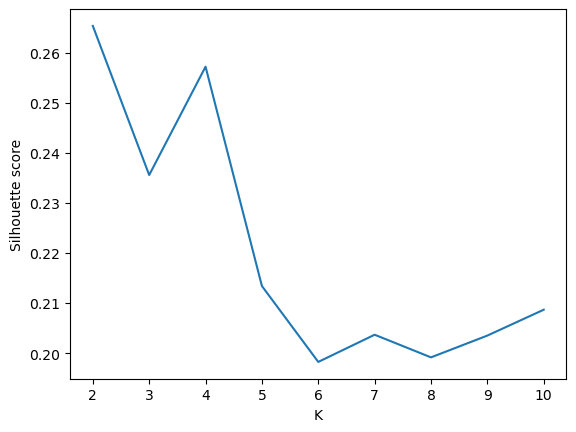

In [10]:
silhouettes = []

# Try multiple k
for k in range(2, 11):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(cluster_df)
    # Get the Silhouette score
    score = silhouette_score(cluster_df, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")


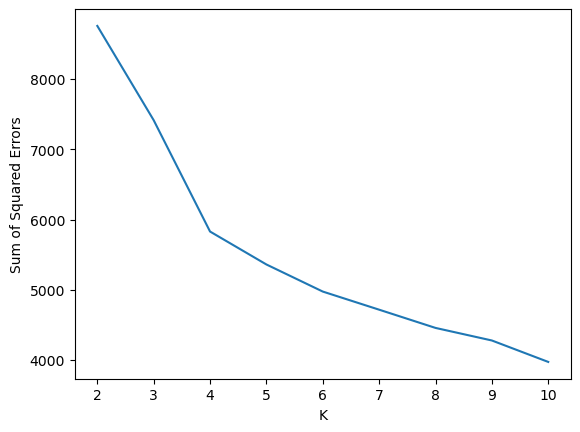

In [11]:
def plot_sse(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(cluster_df)


With the silhouette score we would chose K=2 because it is the heighest with this value. With the sum of squared errors we can observe an "elbow" at K=4. The silhouette score is also relatively heigh at K=4 and it is better suited to have 4 clusters in the case of this task to have a more fine grained distinction of groups, we will therefor go with K=4.

In [12]:
# Clustering with optimal k 
kmeans = KMeans(n_clusters=4,random_state=42)
cluster_df['cluster'] = kmeans.fit_predict(cluster_df)

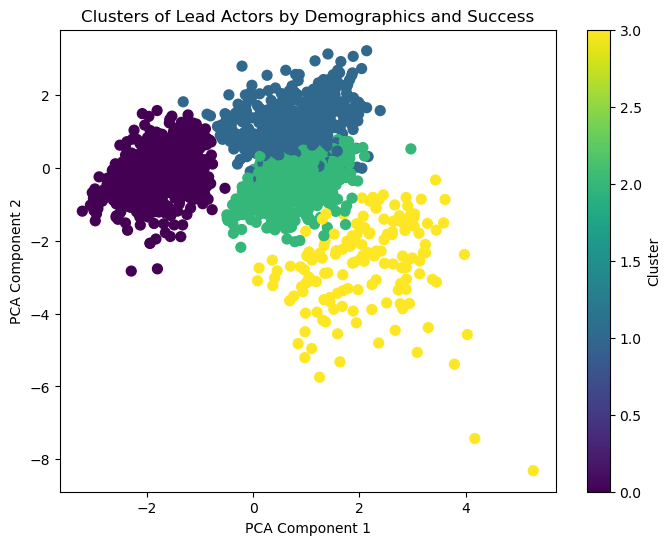

In [25]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(cluster_df)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_df['cluster'], cmap='viridis', s=50)
plt.colorbar(label='Cluster')
plt.title('Clusters of Lead Actors by Demographics and Success')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [20]:
print(pca.components_)

[[ 2.23021709e-11  2.69750486e-09  1.00000000e+00 -2.36783965e-11
  -1.36086329e-10  2.15874925e-10 -2.43571863e-11 -2.18797711e-11
  -3.11684909e-11 -2.29504349e-11  4.42456833e-11 -1.29451446e-10
   1.29451446e-10  1.69498683e-09]
 [ 2.10874323e-03  9.99890136e-01 -2.69478958e-09 -1.62227654e-04
  -1.22737512e-03  3.43903496e-03  3.94745336e-05 -8.78949286e-05
  -1.36812059e-03 -4.87183979e-04 -1.45707323e-04 -9.68276542e-03
   9.68276521e-03 -3.50124180e-03]]


In [14]:
cluster_df_scaled = cluster_df.copy()
cluster_df_scaled[numeric_features]=scaler.inverse_transform(cluster_df[numeric_features])

# Cluster-wise analysis
for cluster_id in sorted(cluster_df_scaled['cluster'].unique()):
    print(f"Cluster {cluster_id}:")
    cluster_data = cluster_df_scaled[cluster_df_scaled['cluster'] == cluster_id]
    print(cluster_data[numeric_features + list(encoded_gender.columns)].mean())  # Numeric summary
    print(cluster_data[['actor_height', 'actor_age_at_release', 'adjusted_box_office']].head(5))  # Sample rows
    print("-" * 40)


Cluster 0:
actor_height            1.668219e+00
actor_age_at_release    3.150613e+01
adjusted_box_office     7.826534e+07
gender_F                9.314928e-01
gender_M                6.850716e-02
dtype: float64
    actor_height  actor_age_at_release  adjusted_box_office
4           1.63                  24.0         1.293273e+05
6           1.78                  40.0         3.005111e+07
9           1.75                  35.0         4.733905e+06
11          1.60                  46.0         1.113572e+08
18          1.69                  30.0         9.943655e+07
----------------------------------------
Cluster 1:
actor_height            1.816345e+00
actor_age_at_release    5.232636e+01
adjusted_box_office     1.054198e+08
gender_F                4.881450e-02
gender_M                9.511855e-01
dtype: float64
    actor_height  actor_age_at_release  adjusted_box_office
8           1.85                  54.0         4.733905e+06
10          1.83                  43.0         1.113572e+

In [15]:
cluster_summary = cluster_df_scaled.groupby('cluster').agg({
    'actor_height': ['mean', 'median', 'min', 'max'],
    'actor_age_at_release': ['mean', 'median', 'min', 'max'],
    'adjusted_box_office': ['mean', 'median', 'min', 'max'],
    'gender_F': 'mean',  # Percentage of female actors in the cluster
    **{f'{group}': 'mean' for group in ['group_African', 'group_Asian', 'group_European',
                                        'group_Hindi', 'group_Indigenous', 'group_Jewish',
                                        'group_Latin American', 'group_Oceanian']},
})

print(cluster_summary)

        actor_height                       actor_age_at_release               \
                mean median     min    max                 mean median   min   
cluster                                                                        
0           1.668219   1.68  1.5200  1.791            31.506135   31.0   9.0   
1           1.816345   1.83  1.5240  2.032            52.326360   50.0  39.0   
2           1.801089   1.80  1.6760  2.160            31.088368   32.0   8.0   
3           1.775711   1.77  1.5494  1.930            36.629139   35.0  11.0   

              adjusted_box_office                ...                gender_F  \
          max                mean        median  ...           max      mean   
cluster                                          ...                           
0        65.0        7.826534e+07  3.960120e+07  ...  5.510136e+08  0.931493   
1        86.0        1.054198e+08  5.547013e+07  ...  5.077547e+08  0.048815   
2        44.0        7.344815e+07  4.16

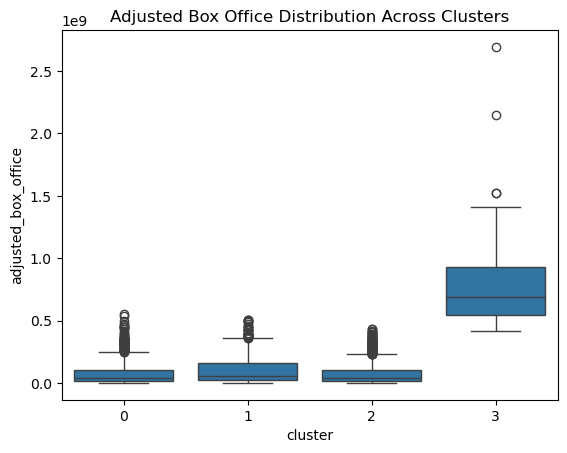

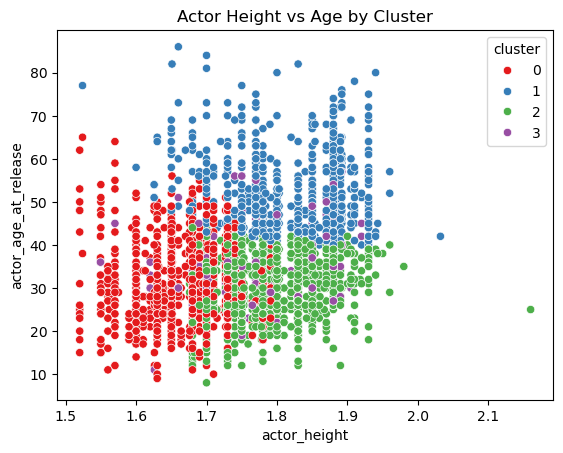

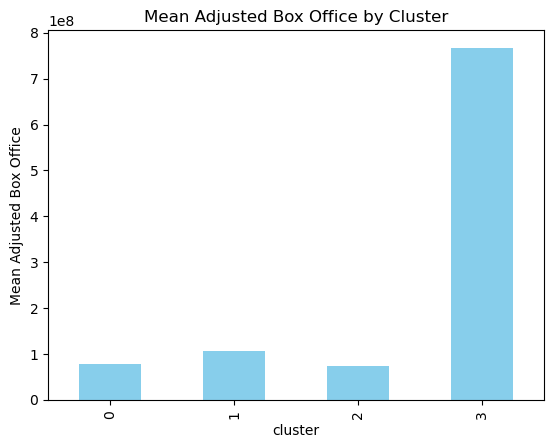

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for adjusted_box_office
sns.boxplot(x='cluster', y='adjusted_box_office', data=cluster_df_scaled)
plt.title("Adjusted Box Office Distribution Across Clusters")
plt.show()

# Scatter plot for height vs age
sns.scatterplot(
    x='actor_height', y='actor_age_at_release',
    hue='cluster', data=cluster_df_scaled, palette='Set1'
)
plt.title("Actor Height vs Age by Cluster")
plt.show()

# Bar plot for mean box office by cluster
cluster_df_scaled.groupby('cluster')['adjusted_box_office'].mean().plot(kind='bar', color='skyblue')
plt.title("Mean Adjusted Box Office by Cluster")
plt.ylabel("Mean Adjusted Box Office")
plt.show()


In [17]:
from sklearn.inspection import permutation_importance

X = cluster_df.drop(columns=['cluster'],axis = 1)
importance = permutation_importance(kmeans, X, cluster_df['cluster'], scoring=None)
pd.DataFrame(importance.importances_mean, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)


,Importance
actor_height,1440.092336
gender_F,911.224946
gender_M,911.224946
actor_age_at_release,382.207424
adjusted_box_office,35.166525
group_European,23.270481
group_African,8.570436
group_Jewish,4.973907
group_Asian,4.337478
group_Latin American,1.014829


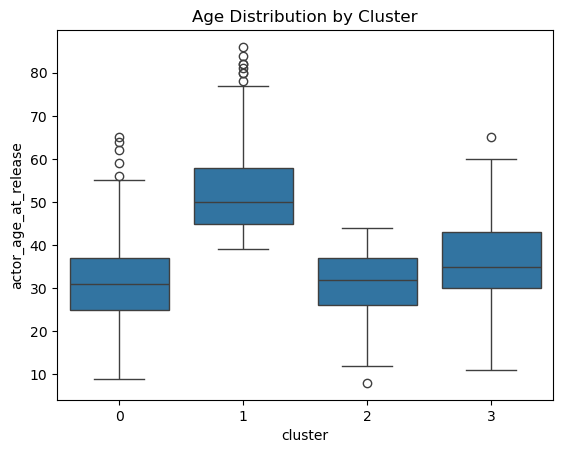

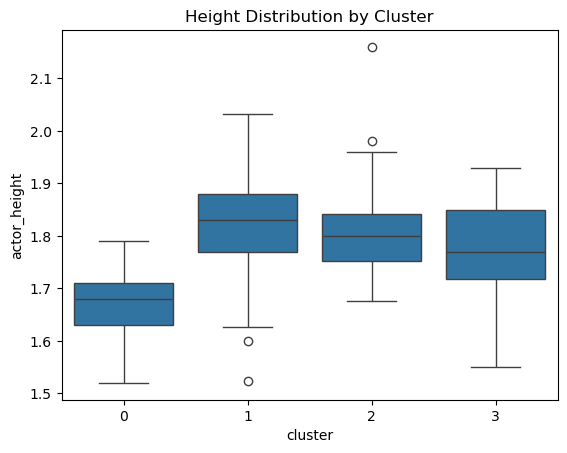

In [18]:
sns.boxplot(x='cluster', y='actor_age_at_release', data=cluster_df_scaled)
plt.title("Age Distribution by Cluster")
plt.show()

sns.boxplot(x='cluster', y='actor_height', data=cluster_df_scaled)
plt.title("Height Distribution by Cluster")
plt.show()


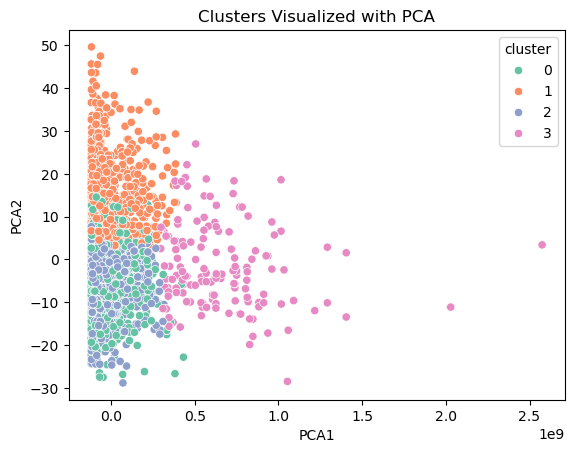

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(cluster_df_scaled)
cluster_df_scaled['PCA1'] = reduced_data[:, 0]
cluster_df_scaled['PCA2'] = reduced_data[:, 1]

sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=cluster_df_scaled, palette='Set2')
plt.title("Clusters Visualized with PCA")
plt.show()
